In [13]:
import os
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### Wczytanie danych

In [1]:

user_name = 'jovyan'
print(user_name)

jovyan


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
.builder \
.config("spark.executor.instances", "4")\
.config('spark.driver.memory','1g') \
.config('spark.executor.memory', '2g') \
.getOrCreate()

In [3]:
# ścieżka dostępu do pliku 
csv_path = 'file:////home/jovyan/data/2020/survey_results_public.csv'

In [4]:
db_name = user_name.replace('-','_')

In [5]:
spark.sql(f'DROP DATABASE IF EXISTS {db_name} CASCADE')
spark.sql(f'CREATE DATABASE {db_name}')
spark.sql(f'USE {db_name}')

DataFrame[]

In [6]:
print(db_name)

jovyan


In [7]:
table_name = "survey_2020"            

In [8]:
spark.sql(f'DROP TABLE IF EXISTS {table_name}')

spark.sql(f'CREATE TABLE IF NOT EXISTS {table_name} \
          USING csv \
          OPTIONS (HEADER true, INFERSCHEMA true, NULLVALUE "NA") \
          LOCATION "{csv_path}"')

DataFrame[]

In [9]:
spark.sql(f'describe {table_name}').show(100)

+--------------------+---------+-------+
|            col_name|data_type|comment|
+--------------------+---------+-------+
|          Respondent|      int|   null|
|          MainBranch|   string|   null|
|            Hobbyist|   string|   null|
|                 Age|   double|   null|
|          Age1stCode|   string|   null|
|            CompFreq|   string|   null|
|           CompTotal|   double|   null|
|       ConvertedComp|   double|   null|
|             Country|   string|   null|
|        CurrencyDesc|   string|   null|
|      CurrencySymbol|   string|   null|
|DatabaseDesireNex...|   string|   null|
|  DatabaseWorkedWith|   string|   null|
|             DevType|   string|   null|
|             EdLevel|   string|   null|
|          Employment|   string|   null|
|           Ethnicity|   string|   null|
|              Gender|   string|   null|
|          JobFactors|   string|   null|
|              JobSat|   string|   null|
|             JobSeek|   string|   null|
|LanguageDesireN

### Przygotowanie danych do analizy

W ramach zadania chcemy stworzyć klasyfikator, który będzie przewidywać czy respondent zarabia więcej niż 60000 USD rocznie.

In [10]:
spark_df = spark.sql(f'SELECT *, CAST((convertedComp > 60000) AS STRING) AS compAboveAvg \
                    FROM {table_name} where convertedComp IS NOT NULL ')

In [11]:
y = 'compAboveAvg'
# na podstawie:
feature_columns = ['OpSys', 'EdLevel', 'MainBranch' , 'Country', 'JobSeek', 'YearsCode']

<b>Ewaluacja </b>

In [14]:
evaluator_AUC = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_ACC = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [15]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

## <span style='background:yellow'> ZADANIA - etap 2A</span>


Odpowiedz korzystając z <b>API DF</b> lub <b>SparkSQL</b>:
    
a) Ile jest unikalnych odpowiedzi w zapytaniu o poziom wykształcenia (EdLevel)?

b) Podaj średnią liczbę godzin przepracowywanych przez z respondentów pogrupowanych ze względu na kraj.

c) Narysuj wykres słupkowy popularności wykorzystywanych baz danych przez profesjonalnych programistów. Skorzystaj z funkcji split i posexplode. 

d)  Sprawdź czy można bardziej poprawić jakość predykcji dla zadania z tego notatnika: 
* dodając cechy?
* zmieniąjac model?
* lepiej dobierajac parametry nowego modelu? 

e) Notatnik zawierający wyniki umieść w repozytorium zespołu w branchu phase-2a.


<b>a) Ile jest unikalnych odpowiedzi w zapytaniu o poziom wykształcenia (EdLevel)? </b>

In [16]:

spark_df = spark.sql(f'SELECT COUNT (DISTINCT EdLevel) as EdLevelCount FROM {table_name}')
spark_df.toPandas()


,EdLevelCount
0,9


ODP: Łącznie z "brakiem wykształcenia" jest 9 poziomów. 

<b>b) Podaj średnią liczbę godzin przepracowywanych przez z respondentów pogrupowanych ze względu na kraj </b>

In [258]:

spark_df = spark.sql(f'SELECT Country, MEAN(WorkWeekHrs) FROM {table_name} where WorkWeekHrs IS NOT NULL GROUP BY Country ORDER BY Country')
spark_df.toPandas()



,Country,mean(WorkWeekHrs)
0,Afghanistan,46.500000
1,Albania,48.392857
2,Algeria,36.862069
3,Andorra,42.000000
4,Angola,72.333333
...,...,...
160,"Venezuela, Bolivarian Republic of...",40.121951
161,Viet Nam,42.371901
162,Yemen,40.000000
163,Zambia,38.000000


Wykorzystanie Spark DF Api (to samo zadanie)

In [17]:
df = spark.read.csv(csv_path, inferSchema=True, header="true", nullValue='NA', nanValue='NA',emptyValue='NA')
df.groupBy("Country").avg("WorkWeekHrs").show()

+--------------------+------------------+
|             Country|  avg(WorkWeekHrs)|
+--------------------+------------------+
|            Paraguay|            29.875|
|The former Yugosl...|              39.5|
|             Senegal|34.285714285714285|
|              Sweden|  40.7496062992126|
|  Hong Kong (S.A.R.)|42.298507462686565|
|   Republic of Korea|35.138888888888886|
|         Philippines| 37.32920792079208|
|           Singapore| 40.25684931506849|
|            Malaysia|39.255639097744364|
|              Turkey| 43.77202643171806|
|              Malawi|              36.5|
|                Iraq| 49.07142857142857|
|             Germany| 40.27298744460857|
|         Afghanistan|              46.5|
|            Cambodia|              44.0|
|              Jordan|45.806451612903224|
|            Maldives|              47.3|
|               Sudan|36.714285714285715|
|              France| 40.38484399375975|
|              Greece| 41.82364341085271|
+--------------------+------------

<b> c) Narysuj wykres słupkowy popularności wykorzystywanych baz danych przez
#profesjonalnych programistów.</b>

In [19]:
from pyspark.sql.functions import posexplode


In [20]:
#Rodzielenie zawartosci kolumny z bazami (założyliśmy, że profesjonalni deweloperzy to tacy, ktorzy maja 
#MainBranch = 'I am a developer by profession'
db = spark.sql(f"SELECT POSEXPLODE(SPLIT(DatabaseWorkedWith, ';'))\
                        FROM {table_name}\
                         WHERE MainBranch = 'I am a developer by profession' ")


In [40]:
stringindexer_stages = [StringIndexer(inputCol='col', outputCol='stringindexed_mapped').setHandleInvalid("error")]
db_mapped = Pipeline(stages=stringindexer_stages).fit(db).transform(db).toPandas()



In [41]:
db_mapped

,pos,col,stringindexed_mapped
0,0,Elasticsearch,8.0
1,1,Microsoft SQL Server,2.0
2,2,Oracle,7.0
3,0,MariaDB,6.0
4,1,MySQL,0.0
...,...,...,...
108474,1,MySQL,0.0
108475,0,Oracle,7.0
108476,0,PostgreSQL,1.0
108477,0,Oracle,7.0


array([[<AxesSubplot: title={'center': 'stringindexed_mapped'}>]],
      dtype=object)

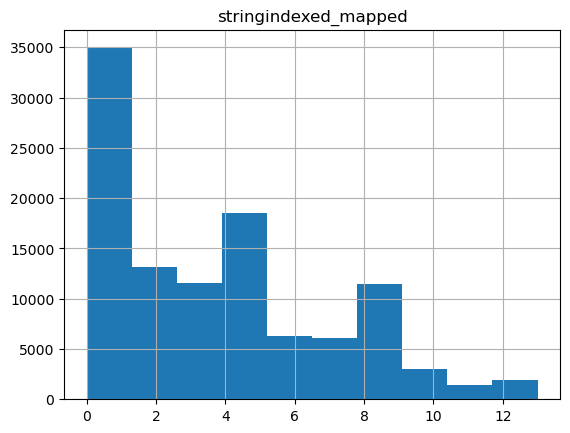

In [42]:
db_mapped.hist('stringindexed_mapped')

<b> d)  Sprawdź czy można bardziej poprawić jakość predykcji dla zadania z tego notatnika: 
* dodając cechy?
* zmieniąjac model?
* lepiej dobierajac parametry nowego modelu? </b>

# <b>Dodawanie cech </b>

Wczytywanie danych

In [43]:
spark_df = spark.sql(f'SELECT *, CAST((convertedComp > 60000) AS STRING) AS compAboveAvg \
                    FROM {table_name} where convertedComp IS NOT NULL ')

Wybór cech. Zostało dodane: 'Employment', 'Age1stCode', 'Hobbyist', 'YearsCodePro'

In [44]:
y = 'compAboveAvg'
feature_columns = ['OpSys', 'EdLevel', 'MainBranch' , 'Country', 'JobSeek', 'YearsCode', 'Employment', 'Age1stCode', 'Hobbyist', 'YearsCodePro']

Tworzenie indekserów oraz onehot-encoderow

In [46]:
stringindexer_stages = [StringIndexer(inputCol=c, outputCol='stringindexed_' + c).setHandleInvalid("keep") for c in feature_columns]
stringindexer_stages += [StringIndexer(inputCol=y, outputCol='label')]
onehotencoder_stages = [OneHotEncoder(inputCol='stringindexed_' + c, outputCol='onehot_' + c) for c in feature_columns]


Tworzenie Vector assemblera

In [47]:
extracted_columns = ['onehot_' + c for c in feature_columns]
vectorassembler_stage = VectorAssembler(inputCols=extracted_columns, outputCol='features') 


In [48]:

final_columns = [y] + feature_columns + extracted_columns + ['features', 'label']

Aplikowanie narzędzi na dane

In [49]:

transformed_df = Pipeline(stages=stringindexer_stages + \
                          onehotencoder_stages + \
                          [vectorassembler_stage]).fit(spark_df).transform(spark_df).select(final_columns)

transformed_df.limit(5).toPandas()

,compAboveAvg,OpSys,EdLevel,MainBranch,Country,JobSeek,YearsCode,Employment,Age1stCode,Hobbyist,...,onehot_MainBranch,onehot_Country,onehot_JobSeek,onehot_YearsCode,onehot_Employment,onehot_Age1stCode,onehot_Hobbyist,onehot_YearsCodePro,features,label
0,true,Linux-based,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",I am a developer by profession,United States,"I’m not actively looking, but I am open to new...",17,Employed full-time,12,Yes,...,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
1,false,Windows,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",I am a developer by profession,United Kingdom,"I’m not actively looking, but I am open to new...",8,Employed full-time,14,Yes,...,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0.0
2,false,Windows,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",I am a developer by profession,United Kingdom,I am actively looking for a job,10,Employed full-time,13,Yes,...,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
3,false,Windows,Some college/university study without earning ...,I am a developer by profession,Spain,"I’m not actively looking, but I am open to new...",7,Employed full-time,42,No,...,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0.0
4,false,MacOS,"Secondary school (e.g. American high school, G...","I am not primarily a developer, but I write co...",Netherlands,I am not interested in new job opportunities,35,Employed full-time,14,Yes,...,"(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0.0


Dzielenie na zbiór treninogwy i testowy

In [50]:
training, test = transformed_df.randomSplit([0.8, 0.2], seed=1234)

Tworzenie instancji modelu

In [51]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

In [53]:
simple_model = Pipeline(stages=[dt]).fit(training)


Predykcja na zbiorze testowym

In [54]:
pred_simple = simple_model.transform(test)

Crossvalidacja

In [81]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
param_grid = ParamGridBuilder().\
    addGrid(dt.maxDepth, [2,3,4,5,6]).\
    build()

cv = CrossValidator(estimator=dt, estimatorParamMaps=param_grid, evaluator=evaluator_AUC, numFolds=4)
cv_model = cv.fit(training)
pred_cv = cv_model.transform(test)


Miary jakości

In [143]:
results_df = pd.DataFrame(columns = ['model','AUC', 'ACC', 'AUC_CV', 'ACC_CV'])
original_results = {'model': 'original', 'AUC':0.5849450757845746, 'ACC': 0.7811496936095711 , 'AUC_CV':0.6802717764826989 , 'ACC_CV': 0.756638459293843  }
results_df = results_df.append(original_results, ignore_index = True)
results_df

/tmp/ipykernel_126/2296730402.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(original_results, ignore_index = True)


,model,AUC,ACC,AUC_CV,ACC_CV
0,original,0.584945,0.78115,0.680272,0.756638


In [83]:
accuracy = evaluator_ACC.evaluate(pred_simple)
# print(f"accuracy {accuracy}")
auroc = evaluator_AUC.evaluate(pred_simple)
# print(f"auc {auroc_simple}")

accuracy_cv = evaluator_ACC.evaluate(pred_cv)
# print(f"accuracy CV: {accuracy_cv}")
auroc_cv = evaluator_AUC.evaluate(pred_cv)
# print(f"auc CV: {auroc_cv}")


added_feature= {'model': 'added feature', 'AUC':auroc_simple, 'ACC': accuracy , 'AUC_CV':auroc_cv, 'ACC_CV': accuracy_cv   }
results_df = results_df.append(added_feature, ignore_index = True)
results_df

/tmp/ipykernel_126/3658009221.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(added_feature, ignore_index = True)


,model,AUC,ACC,AUC_CV,ACC_CV
0,original,0.584945,0.781150,0.680272,0.756638
1,added feature,0.681640,0.792092,0.769210,0.774730


Dodanie nowych cech przyczynia się do lepszych wyników dla modelu.

# <b>Zmiana cech </b>

Postanowiliśmi nie indeksować zmiennych numerycznych (które mogą nieśc za sobą informacje - takich jak ilośc przepracowanego czasu), aby sprawdzić czy poprawi to jakośc predykcji

Wczytywanie danych

In [129]:
spark_df = spark.sql(f'SELECT *, CAST((convertedComp > 60000) AS STRING) AS compAboveAvg \
                    FROM {table_name} where convertedComp IS NOT NULL ')

Wybór cech. Postanowniono nie indeksować ['YearsCode','Age1stCode','YearsCodePro']

In [130]:
y = 'compAboveAvg'
feature_columns = ['OpSys', 'EdLevel', 'MainBranch' , 'Country', 'JobSeek', 'YearsCode', 'Employment', 'Age1stCode', 'Hobbyist', 'YearsCodePro']
feature_to_index = ['OpSys', 'EdLevel', 'MainBranch' , 'Country', 'JobSeek', 'Employment','Hobbyist']
feature_no_index = ['YearsCode','Age1stCode','YearsCodePro']

Zmiana typu danych na int dla kolumn numerycznych oraz zastąpienie braków wartości zerami

In [131]:
from pyspark.sql.types import IntegerType
for feature in feature_no_index:       
    spark_df = spark_df.withColumn(feature, spark_df[feature].cast(IntegerType()))
    spark_df = spark_df.na.fill(0, subset = [feature])

Tworzenie indekserów oraz onehot-encoderow

In [132]:
stringindexer_stages = [StringIndexer(inputCol=c, outputCol='stringindexed_' + c).setHandleInvalid("keep") for c in feature_to_index]
stringindexer_stages += [StringIndexer(inputCol=y, outputCol='label')]
feature_to_encode = ['stringindexed_' + c for c in feature_to_index] 
onehotencoder_stages = [OneHotEncoder(inputCol= c, outputCol='onehot_' + c) for c in feature_to_encode] 

Tworzenie Vector assemblera

In [133]:
extracted_columns = ['onehot_' + c for c in feature_to_encode] + feature_no_index
vectorassembler_stage = VectorAssembler(inputCols= extracted_columns, outputCol='features')


In [134]:

final_columns = [y] + feature_columns + extracted_columns + ['features', 'label']

Aplikowanie narzędzi na dane

In [135]:

transformed_df = Pipeline(stages=stringindexer_stages + \
                          onehotencoder_stages +\
                          [vectorassembler_stage]).fit(spark_df).transform(spark_df)
transformed_df.limit(5).toPandas()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,stringindexed_Hobbyist,label,onehot_stringindexed_OpSys,onehot_stringindexed_EdLevel,onehot_stringindexed_MainBranch,onehot_stringindexed_Country,onehot_stringindexed_JobSeek,onehot_stringindexed_Employment,onehot_stringindexed_Hobbyist,features
0,8,I am a developer by profession,Yes,36.0,12,Yearly,116000.0,116000.0,United States,United States dollar,...,0.0,1.0,"(0.0, 0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,10,I am a developer by profession,Yes,22.0,14,Yearly,25000.0,32315.0,United Kingdom,Pound sterling,...,0.0,0.0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,11,I am a developer by profession,Yes,23.0,13,Yearly,31000.0,40070.0,United Kingdom,Pound sterling,...,0.0,0.0,"(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0)","(1.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,12,I am a developer by profession,No,49.0,42,Monthly,1100.0,14268.0,Spain,European Euro,...,1.0,0.0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
4,13,"I am not primarily a developer, but I write co...",Yes,53.0,14,Monthly,3000.0,38916.0,Netherlands,European Euro,...,0.0,0.0,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


Dzielenie na zbiór treninogwy i testowy

In [136]:
training, test = transformed_df.randomSplit([0.8, 0.2], seed=1234)

Tworzenie instancji modelu

In [137]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

In [138]:
simple_model = Pipeline(stages=[dt]).fit(training)


Predykcja na zbiorze testowym

In [139]:
pred_simple = simple_model.transform(test)

Crossvalidacja

In [140]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
param_grid = ParamGridBuilder().\
    addGrid(dt.maxDepth, [2,3,4,5,6]).\
    build()

cv = CrossValidator(estimator=dt, estimatorParamMaps=param_grid, evaluator=evaluator_AUC, numFolds=4)
cv_model = cv.fit(training)
pred_cv = cv_model.transform(test)


Miary jakości

In [144]:
accuracy = evaluator_ACC.evaluate(pred_simple)
#print(f"accuracy {accuracy}")
auroc_simple = evaluator_AUC.evaluate(pred_simple)
#print(f"auc {auroc_simple}")

pred_cv = cv_model.transform(test)
accuracy_cv = evaluator_ACC.evaluate(pred_cv)
# print(f"accuracy CV: {accuracy}")
auroc_cv = evaluator_AUC.evaluate(pred_cv)
# print(f"auc CV: {auroc_simple}")


changed_feature= {'model': 'changed feature', 'AUC':auroc_simple, 'ACC': accuracy , 'AUC_CV':auroc_cv, 'ACC_CV': accuracy_cv   }
results_df = results_df.append(changed_feature, ignore_index = True)
results_df

/tmp/ipykernel_126/3432520056.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(changed_feature, ignore_index = True)


,model,AUC,ACC,AUC_CV,ACC_CV
0,original,0.584945,0.781150,0.680272,0.756638
1,changed feature,0.691247,0.792092,0.769210,0.774730


Zmiana cech przyczynilła się do dość dużego wzrostu AUC. 

# <b> Zmiana modelu </b>

GBTrees

In [145]:
from pyspark.ml.classification import GBTClassifier

Tworzenie i trenowanie modelu

In [146]:

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
simple_model = Pipeline(stages=[gbt]).fit(training)


Predykcja na zbiorze testowym

In [147]:
pred_simple = simple_model.transform(test)

Crossvalidacja

In [148]:
param_grid = ParamGridBuilder().\
    addGrid(gbt.maxDepth, [2,3,4,5,6]).\
    build()

cv = CrossValidator(estimator = gbt, estimatorParamMaps=param_grid, evaluator=evaluator_AUC, numFolds=4)
cv_model = cv.fit(training)
pred_cv = cv_model.transform(test)


Miary jakości

In [149]:
accuracy = evaluator_ACC.evaluate(pred_simple)
#print(f"accuracy {accuracy}")
auroc_simple = evaluator_AUC.evaluate(pred_simple)
#print(f"auc {auroc_simple}")

pred_cv = cv_model.transform(test)
accuracy_cv = evaluator_ACC.evaluate(pred_cv)
# print(f"accuracy CV: {accuracy}")
auroc_cv = evaluator_AUC.evaluate(pred_cv)
# print(f"auc CV: {auroc_simple}")


gbt_results = {'model': 'GBTrees', 'AUC':auroc_simple, 'ACC': accuracy , 'AUC_CV':auroc_cv, 'ACC_CV': accuracy_cv   }
results_df = results_df.append(gbt_results, ignore_index = True)
results_df

/tmp/ipykernel_126/463366619.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(gbt_results, ignore_index = True)


,model,AUC,ACC,AUC_CV,ACC_CV
0,original,0.584945,0.781150,0.680272,0.756638
1,changed feature,0.691247,0.792092,0.769210,0.774730
2,GBTrees,0.896106,0.806682,0.904059,0.823169


<b> SVM </b>

In [150]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1)

In [151]:

simple_model = Pipeline(stages=[lsvc]).fit(training)


Predykcja na zbiorze testowym

In [152]:
pred_simple = simple_model.transform(test)

Crossvalidacja

In [153]:
lsvc = LinearSVC(maxIter=10)
param_grid = ParamGridBuilder().\
    addGrid(lsvc.regParam, [0.1, 0.2, 0.5, 0.7, 0.9, 1]).\
    build()

cv = CrossValidator(estimator = lsvc, estimatorParamMaps=param_grid, evaluator=evaluator_AUC, numFolds=4)
cv_model = cv.fit(training)
pred_cv = cv_model.transform(test)


Miary jakości

In [154]:
accuracy = evaluator_ACC.evaluate(pred_simple)
#print(f"accuracy {accuracy}")
auroc_simple = evaluator_AUC.evaluate(pred_simple)
#print(f"auc {auroc_simple}")

pred_cv = cv_model.transform(test)
accuracy_cv = evaluator_ACC.evaluate(pred_cv)
# print(f"accuracy CV: {accuracy}")
auroc_cv = evaluator_AUC.evaluate(pred_cv)
# print(f"auc CV: {auroc_simple}")


svm_results = {'model': 'SVM', 'AUC':auroc_simple, 'ACC': accuracy , 'AUC_CV':auroc_cv, 'ACC_CV': accuracy_cv   }
results_df = results_df.append(svm_results, ignore_index = True)
results_df

/tmp/ipykernel_126/2429049388.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(svm_results, ignore_index = True)


,model,AUC,ACC,AUC_CV,ACC_CV
0,original,0.584945,0.781150,0.680272,0.756638
1,changed feature,0.691247,0.792092,0.769210,0.774730
2,GBTrees,0.896106,0.806682,0.904059,0.823169
3,SVM,0.908952,0.818646,0.910720,0.826525


Widać, że model SVM daje w tym przypadku najlepsze rezultaty. Zmiana modelu przyniosła pozytywne rezultaty

<b> RandomForest </b>

In [155]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=60)

In [156]:
simple_model = Pipeline(stages=[rf]).fit(training)


Predykcja na zbiorze testowym

In [157]:
pred_simple = simple_model.transform(test)

Crossvalidacja

In [158]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
param_grid = ParamGridBuilder().\
    addGrid(rf.maxDepth, [2,3,4,5,6]).\
    addGrid(rf.numTrees, [60,120,300]).\
    build()

cv = CrossValidator(estimator = rf, estimatorParamMaps=param_grid, evaluator=evaluator_AUC, numFolds=4)
cv_model = cv.fit(training)
pred_cv = cv_model.transform(test)


Miary jakości

In [159]:
accuracy = evaluator_ACC.evaluate(pred_simple)
#print(f"accuracy {accuracy}")
auroc_simple = evaluator_AUC.evaluate(pred_simple)
#print(f"auc {auroc_simple}")

pred_cv = cv_model.transform(test)
accuracy_cv = evaluator_ACC.evaluate(pred_cv)
# print(f"accuracy CV: {accuracy}")
auroc_cv = evaluator_AUC.evaluate(pred_cv)
# print(f"auc CV: {auroc_simple}")


rf_results = {'model': 'RandomForest', 'AUC':auroc_simple, 'ACC': accuracy , 'AUC_CV':auroc_cv, 'ACC_CV': accuracy_cv   }
results_df = results_df.append(rf_results, ignore_index = True)
results_df

/tmp/ipykernel_126/580908923.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(rf_results, ignore_index = True)


,model,AUC,ACC,AUC_CV,ACC_CV
0,original,0.584945,0.781150,0.680272,0.756638
1,changed feature,0.691247,0.792092,0.769210,0.774730
2,GBTrees,0.896106,0.806682,0.904059,0.823169
3,SVM,0.908952,0.818646,0.910720,0.826525
4,RandomForest,0.881190,0.800263,0.888384,0.807995
